_Version log: Finding the best samples though brute force and manual tweaking. Also started to compare different optimisation results._

In [1]:
import CS_functions as cs
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt, colors as mplcolors
plt.rcParams.update({'font.size':16, 'xtick.minor.visible': True, 'ytick.minor.visible': False})
#np.set_printoptions(threshold=sys.maxsize)

In [2]:
file_name = "1dmockanderrors15"
file_type = ".csv"
reduced_points = 4

target, uncertainties = cs.open_dataset(file_name, file_type)
#uncertainties = np.ones_like(uncertainties)
total_points = len(target)
optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [3]:
full_data = cs.open_csv(optlocs_file, reduced_points)

In [4]:
#test = [11,15,24,27,44,66,85,126] #PCA
#test = [72,76,79,89,96,100,107,117] #RPCA
test = [100,93,88,84] # Manual
#test = [41,42,45,46,58,59,63,65] # SA
#test = [18,36,52,56,59,71,77,86] #MCMC
#test = [107,106,120,75,84,100] #Brute force
#test = cs.subsample_1d(total_points, reduced_points, subsampling_method= "regular") # referance

test = np.array(test)

len(test)

4

In [5]:
full_data = np.vstack([full_data, test])
full_data.shape

(55, 4)

In [6]:
regularization_coeffient = 1e-3

def find_error(locations):
    assert locations.ndim == 1
    locations = locations[~np.isnan(locations)].astype(int)

    samples = np.full_like(target, np.nan)
    samples[locations] = target[locations]
    result = cs.compressed_sensing(samples, regularization_coeffient)
    error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

    return error

errors = [find_error(locations) for locations in tqdm(full_data)]
errors = np.array(errors)


100%|██████████| 55/55 [00:00<00:00, 131.00it/s]


In [7]:
sort = np.argsort(errors)
print(errors[-1])
errors = errors[sort]
full_data = full_data[sort]

1.4140067623273018


In [8]:
print(*zip(errors, full_data), sep= "\n")

(0.8832183762894411, array([100,  95,  90,  96]))
(1.1567823524973349, array([105, 100,  90,  99]))
(1.4140067623273018, array([100,  93,  88,  84]))
(1.4140067623273018, array([100,  93,  88,  84]))
(1.4140067623273018, array([100,  93,  88,  84]))
(2.4378357749357638, array([100,  93,  74,  86]))
(2.4669853467198255, array([106, 101,  95,   0]))
(2.9737076513799265, array([ 78, 131, 162, 176]))
(3.0753120560647154, array([ 37,  51,  76, 132]))
(3.081731947749952, array([12, 33, 56, 66]))
(3.0835077810544926, array([100, 100, 100, 100]))
(3.0835077810544926, array([  9,  57, 132, 194]))
(3.083555962664638, array([ 20,  49,  66, 155]))
(3.085901496753061, array([ 76, 146, 150, 178]))
(3.09551360777132, array([ 43,  66, 121, 188]))
(3.103283034007616, array([ 58,  70, 119, 150]))
(3.1315682892590035, array([ 74,  78, 131, 159]))
(3.1334048128160084, array([ 76,  83, 122, 170]))
(3.2167100963403077, array([ 77, 117, 124, 143]))
(3.227173130293927, array([ 99,  97, 103, 103]))
(3.23746368

In [9]:
sa_error = find_error(test)
brute_errors = np.empty((reduced_points, total_points))

fixed_points = np.repeat(test[None, :], reduced_points, axis= 0)
fixed_points = fixed_points[~np.eye(reduced_points, dtype= bool)] #one of the samples is not fixed
fixed_points = fixed_points.reshape((reduced_points, reduced_points-1)) #tell numpy to stop flattening my array

for n in np.arange(reduced_points):
    trail_samples = np.copy(test)
    for trail_sample in np.arange(total_points):
        trail_samples[n] = trail_sample
        brute_error = find_error(trail_samples) #This is the chi-squared
        brute_errors[n, trail_sample] = brute_error

-0.26276048948654207


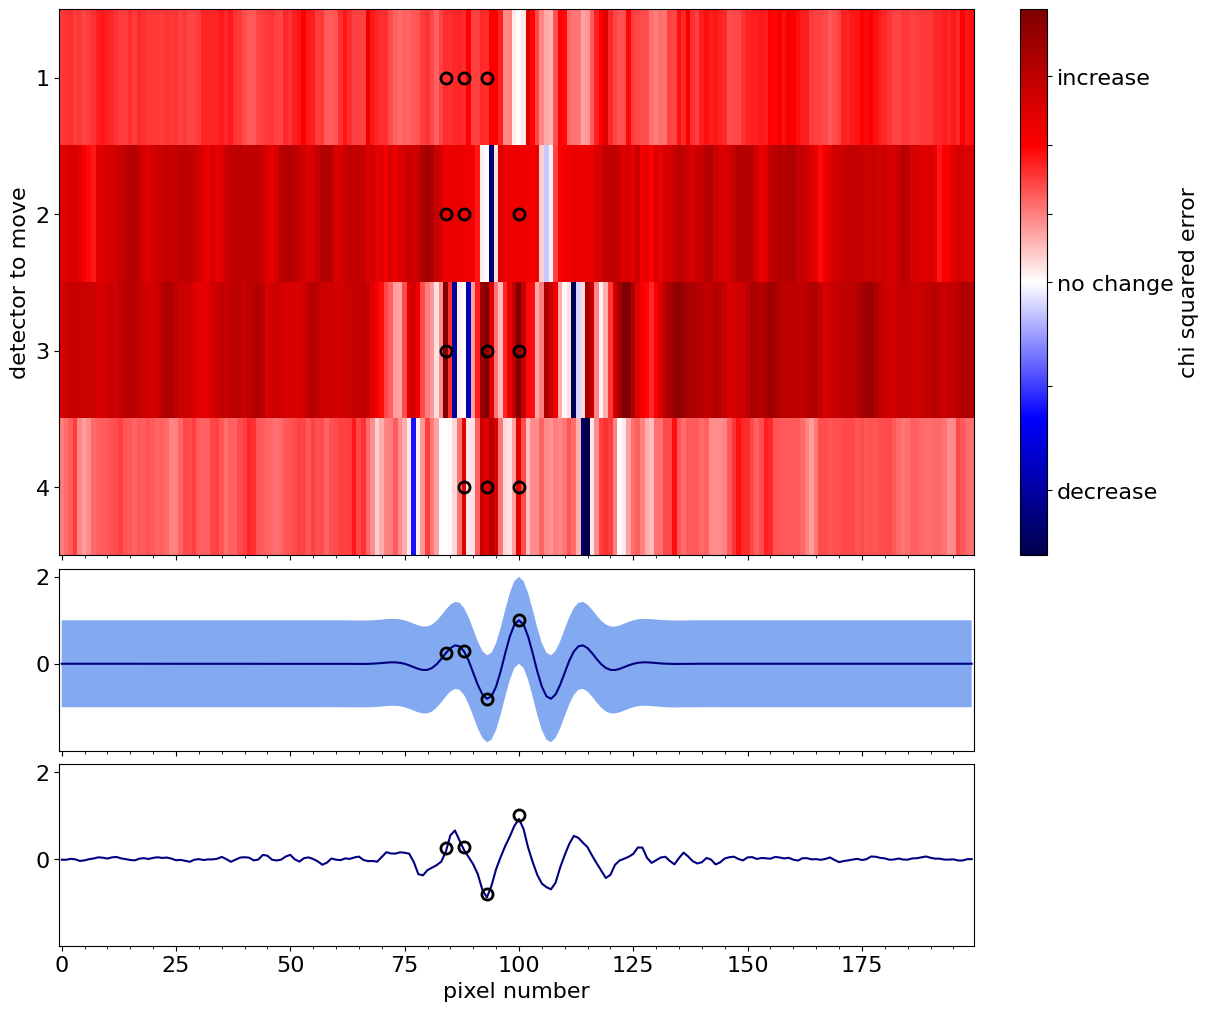

In [10]:
difference = brute_errors -sa_error

max_diff = np.max(difference)
min_diff = np.min(difference)
print(min_diff) # If this is less than zero then SA failed to find the best solution.
if min_diff >= 0: min_diff = -1 #If this is more than or equal to zero then my code breaks!
if max_diff <= 0: max_diff = 1 #If this is less than or equal to zero then my code breaks!

pos_zticks = np.arange(0, max_diff, 10**np.floor(np.log10(np.abs(max_diff))))
neg_zticks = np.arange(0, min_diff, -10**np.floor(np.log10(np.abs(min_diff)))) # np.floor() is NOT the same as int() for negative numbers!
zticks = np.unique(np.concatenate([pos_zticks, neg_zticks]))

zticklabels = np.full_like(zticks, "", dtype= object)
zticklabels[0] = "decrease"
zticklabels[-1] = "increase"
zticklabels[zticks == 0] = "no change"

fig, axs = plt.subplots(3, 1, figsize= (12, 10), sharex= True, height_ratios= (3, 1, 1), layout= "constrained")

norm = mplcolors.TwoSlopeNorm(0, vmin=min_diff, vmax=max_diff) #Greatly exagerates the possible improvements
im = axs[0].imshow(difference, aspect= "auto", interpolation= "none", cmap= "seismic", norm= norm)
cbar = fig.colorbar(im, label= "chi squared error")
cbar.set_ticks(ticks= zticks, labels=zticklabels)

axs[0].plot(fixed_points ,np.arange(reduced_points), linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8) #kind of cursed but it works
axs[0].set(ylabel= "detector to move", yticks= np.arange(reduced_points), yticklabels= np.arange(1, reduced_points+1))

axs[1].plot(target, color= "navy", label= "actual signal")
axs[1].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "cornflowerblue", alpha= 0.8, label= "± std uncertrainty")
axs[1].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)

samples = np.full_like(target, np.nan)
samples[test] = target[test]

axs[2].plot(cs.compressed_sensing(samples, regularization_coeffient), color= "navy")
axs[2].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)
axs[2].set(xlabel= "pixel number", ylim= axs[1].get_ylim())

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_19084\2520619779.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


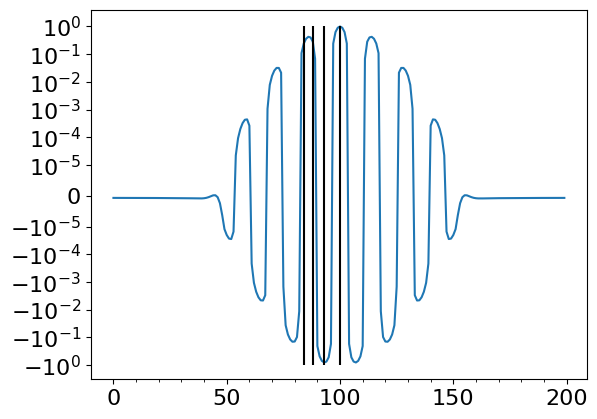

In [11]:
fig, axs = plt.subplots()

axs.plot(target)
axs.set_yscale("symlog", linthresh= 1e-5)
axs.vlines(test, -1, 1, colors= "k")
fig.show()